# Real World Evidence (#67675) - Project

## Accidental death by fatal drug overdose is a rising trend in the United States. What can we do to help?

The data set used in this project was obtained from https://www.kaggle.com/apryor6/us-opiate-prescriptions

## Data

* `overdoses.csv` - Statistics on opioid related drug overdoses in 2014
* `prescriber-info.csv` - Prescription drug information by doctor in the U.S. 2014
* `opioids.csv` - List of drugs classified as opiates

## Imports

In [224]:
from matplotlib import style as style
import matplotlib.pyplot as plt
style.use('ggplot')
import pandas as pd
import numpy as np
import re
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Descriptive Statistics

### State Overdose Statistics

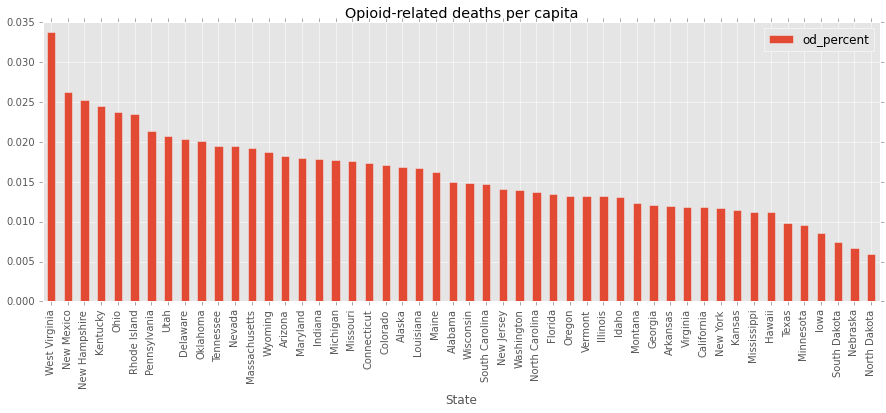

In [225]:
state_ods = pd.read_csv('data/overdoses.csv', thousands=',')
state_ods['od_percent'] = 100 * (state_ods.Deaths / state_ods.Population)
state_ods = state_ods.sort('od_percent', ascending=False)
state_ods.plot(kind='bar', x='State', y='od_percent', title="Opioid-related deaths per capita", figsize=(15,5))
show()

Focusing on the top-10 states, with respect to the percentage of opioid-related overdoses, we see a cluster of east-coast states:

![caption](img/highest_percentage_states.png)

### Prescriber Statistics

#### Cleaning the Data

In [226]:
prescriber_info = pd.read_csv('data/prescriber-info.csv', thousands=',')
# remove states with a low number of opioid prescribers
state_sizes = prescriber_info.groupby('State').size()
large_state_ops = state_sizes[state_sizes > 50]
idxs = prescriber_info.apply(lambda r: r.State in large_state_ops.index , axis=1) 
filtered_prescriber_info = prescriber_info[idxs].copy()
# merge similar\small specialties
filtered_prescriber_info = filtered_prescriber_info.replace('.*Surgery.*', 'General Surgery', regex=True)
specialty_group_sizes = filtered_prescriber_info.groupby('Specialty').size()
small_specialty_groups = specialty_group_sizes[specialty_group_sizes < 20]
filtered_prescriber_info.replace(small_specialty_groups.index, 'Other', inplace=True)
prescriber_info = filtered_prescriber_info

C:\Anaconda3\lib\site-packages\pandas\core\common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
C:\Anaconda3\lib\site-packages\pandas\core\common.py:523: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


#### Opioid Prescribers per Capita

In [227]:
opiad_prescriber_idxs = prescriber_info.apply(lambda r: r['Opioid.Prescriber'] == 1, axis=1)
opiad_prescriber_info = prescriber_info[opiad_prescriber_idxs]
opiad_prescriber_state_grp = opiad_prescriber_info.groupby(['State'])
states = [sn for sn, g in opiad_prescriber_state_grp]
opiad_prescribers_state_count = pd.DataFrame({'Abbrev': states, 'num_of_prescribers': opiad_prescriber_state_grp.size()})
join_ods_prescribers = pd.merge(state_ods, opiad_prescribers_state_count, how='inner', on=['Abbrev'])
join_ods_prescribers['presciber_per_capita'] = 100 * join_ods_prescribers['num_of_prescribers'] / join_ods_prescribers['Population'] 
join_ods_prescribers = join_ods_prescribers.sort_values('presciber_per_capita', ascending=False)
join_ods_prescribers.plot(kind='bar', x='State', y='presciber_per_capita', title="Opioid prescribers per capita", figsize=(15,5))
show()

AttributeError: 'DataFrame' object has no attribute 'sort_values'

#### Correlation between opioid deaths per capita and opioid prescribers per capita 

In [228]:
ods_vs_prescribers = join_ods_prescribers[['od_percent','presciber_per_capita']]
ods_vs_prescribers_mat = ods_vs_prescribers.values.transpose()
rho, pvalue = spearmanr(ods_vs_prescribers_mat[0,:], ods_vs_prescribers_mat[1,:])
print('rho: ' + str(rho))
print('p-value: ' + str(pvalue))

rho: 0.369083803734
p-value: 0.00983612473327


#### Which field has the most amount of doctors who prescribe opioids?

In [229]:
specialty_size = opiad_prescriber_info.groupby('Specialty').size()
specialty_size.sort_values(inplace=True, ascending=False)
specialty_size.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Number of Opioid Prescribers per Specialty", figsize=(15,5))
show()

AttributeError: 'Series' object has no attribute 'sort_values'

Which field has most of its doctors being opiads prescribers

In [230]:
specialty_size = opiad_prescriber_info.groupby('Specialty').size() / prescriber_info.groupby('Specialty').size() * 100
specialty_size.sort_values(inplace=True, ascending=False)
specialty_size.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Percent of Opioid Prescribers per Specialty", figsize=(15,5))
show()


AttributeError: 'Series' object has no attribute 'sort_values'

### West Virginia vs. North Dakota - A Case Study

As we saw, West Virgina has the highest number of opioid-related deaths per capita, whereas North Dakota has the lower number. 

It would be interesting to compare the opioid prescription statistics in both states.  

In [231]:
opioids = pd.read_csv('data/opioids.csv')
op_names = opioids['Drug Name']
cleaned_op_names = op_names.apply(lambda name: re.sub("\ |-",".",str(name)))
prescibers_columns = prescriber_info.columns
common_drugs = set(prescibers_columns).intersection(set(cleaned_op_names))
prescriber_info_only_opioids_and_state = prescriber_info[['State'] + list(common_drugs)]
#prescriber_info_no_opioids = prescriber_info[list(set(prescriber_info.columns) - common_drugs)]
prescriber_info_no_opioids = prescriber_info.copy()
for drug in common_drugs:
    prescriber_info_no_opioids = prescriber_info_no_opioids.drop(drug, 1)
state_opioid_pres_sums = prescriber_info_only_opioids_and_state.groupby('State').sum()
WV_pop = state_ods[state_ods.Abbrev == 'WV'].Population.values
ND_pop = state_ods[state_ods.Abbrev == 'ND'].Population.values

WV_pres_norm = state_opioid_pres_sums.iloc[state_opioid_pres_sums.index.get_loc('WV')].values / WV_pop
ND_pres_norm = state_opioid_pres_sums.iloc[state_opioid_pres_sums.index.get_loc('ND')].values / ND_pop
general_prescription_ratio = sum(WV_pres_norm)/sum(ND_pres_norm)
print('Prescription ratio: ' + str(general_prescription_ratio))

Prescription ratio: 1.56228259001


We see here that in general, opioids are prescribed in West Virginia 1.5-times as much as in North Dakota.

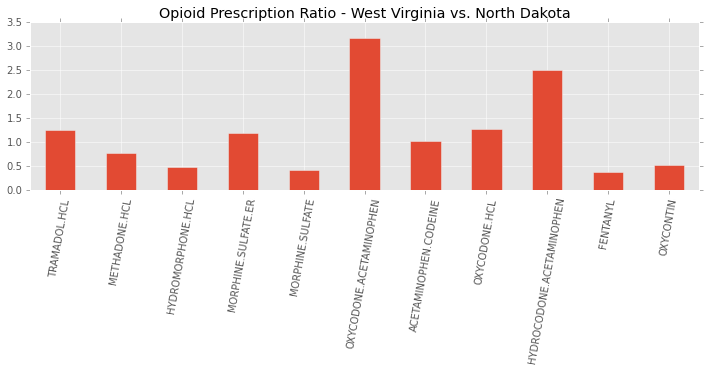

In [232]:
WV_ND_ratio = WV_pres_norm / ND_pres_norm
ratio_series = pd.Series.from_array(WV_ND_ratio)  
x_labels = state_opioid_pres_sums.columns
plt.figure(figsize=(12, 3))
ax = ratio_series.plot(kind='bar')
ax.set_title("Opioid Prescription Ratio - West Virginia vs. North Dakota")
ax.set_xticklabels(x_labels, rotation = 80)
show()

*Note that we first normalized the number of prescriptions by the total population at each state.*

This graph shows that some opioids are prescripted much more in West Virginia than in North Dakota.

Interestingly, OXYCODONE\ACETAMINOPHEN is prescribed in West Virginia more than three times as much as in North Dakota.

## Classification

### Predicting Opioid Prescriptions 

Exploring the characteristics of opioid prescribers could be helpful in several ways:
* Understanding the medical fields and specialties in which opioids are used can shed light on the areas in which  special attention and awareness is needed.   
* Understanding drug prescription connections and habits can help spot possible dangers, and bring to attention areas which should be furter researched.
* Illegal trading of opioids is a serious problem on its own, so this could be a way of discovering illegitimate drug access.

In [233]:
from sklearn.ensemble import RandomForestClassifier

prescriber_info_facts = prescriber_info.copy()
# factorize the 'Gender', 'State', 'Credentials', 'Specialty' columns so all the data will be numeric
cats_to_factorize = ['Gender', 'State', 'Credentials', 'Specialty']
prescriber_info_facts[cats_to_factorize] = prescriber_info_facts[cats_to_factorize].apply(lambda x: pd.factorize(x)[0]) 
train, test = train_test_split(prescriber_info_facts,test_size=0.2, random_state=17)
train_features = train.iloc[:, 1:-1]
train_labels = train.iloc[:,-1]
# train:
rfc = RandomForestClassifier(n_estimators=20, random_state=13)
rfc.fit(train_features, train_labels)
# test
test_features = test.iloc[:, 1:-1]
test_labels = test.iloc[:,-1]
rfc.score(test_features, test_labels)

0.92574754164158135

Classifiying while removing all opiodes from data

In [234]:
from sklearn.ensemble import RandomForestClassifier

prescriber_info_facts = prescriber_info_no_opioids.copy()
# factorize the 'Gender', 'State', 'Credentials', 'Specialty' columns so all the data will be numeric
cats_to_factorize = ['Gender', 'State', 'Credentials', 'Specialty']
prescriber_info_facts[cats_to_factorize] = prescriber_info_facts[cats_to_factorize].apply(lambda x: pd.factorize(x)[0]) 
train, test = train_test_split(prescriber_info_facts,test_size=0.2, random_state=17)
train_features = train.iloc[:, 1:-1]
train_labels = train.iloc[:,-1]
# train:
rfc = RandomForestClassifier(n_estimators=20, random_state=13)
rfc.fit(train_features, train_labels)
# test
test_features = test.iloc[:, 1:-1]
test_labels = test.iloc[:,-1]
rfc.score(test_features, test_labels)

0.83905277945013046

Showing the important features

(243,)


(-1, 20)

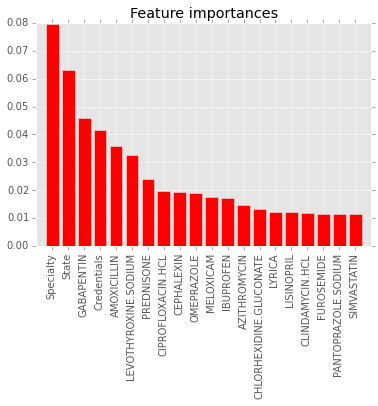

In [235]:
importances = rfc.feature_importances_
print (importances.shape)
indices = np.argsort(importances)[::-1]
column_names = list(train_features)

# for idx in indices:
#     print(column_names[idx] + " importance: %f" %importances[idx])

plt.figure()
plt.title("Feature importances")
ordered_col_names = [ column_names[i] for i in indices[:20]]
plt.bar(range(20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), ordered_col_names[:20], rotation = 90)
plt.xlim([-1, 20])